# FAA flight delay data

Notebook exploring the [FAA On-Time Performance data](https://www.transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time).

In [1]:
import os
import warnings
import json
import copy
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
# Load data
DIR = './data/original/'

csv_paths = [
    os.path.join(path, f) for path, _, files in os.walk(DIR) for f in files 
    if f.endswith('.csv')]

print('{} files found.'.format(len(csv_paths)))


TYPES = {
    'MONTH': int,
    'DAY_OF_MONTH': int,
    'DAY_OF_WEEK': int,
    'UNIQUE_CARRIER': str,
    'TAIL_NUM': str,
    'ORIGIN': str,
    'ORIGIN_CITY_NAME': str,
    'DEST': str,
    'DEST_CITY_NAME': str,
    'CRS_DEP_TIME': int,
    'DEP_DELAY': float,
    'CRS_ARR_TIME': int,
    'ARR_DELAY': float,
    'CRS_ELAPSED_TIME': float,
    'DISTANCE': float
}

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

dfs = [
    pd.read_csv(
        filepath, sep=',', header=0, dtype=TYPES, 
        infer_datetime_format=True, parse_dates=['FL_DATE'], date_parser=dateparse)
    for filepath in csv_paths
]
print('{} files loaded.'.format(len(dfs)))

df = pd.concat(dfs)

12 files found.
12 files loaded.


In [3]:
print('Number of columns in training: ', len(df.columns))
print('Number of rows in training: ', len(df))

with pd.option_context('display.max_rows', 3, 'display.max_columns', 300):
    display(df)
    
with pd.option_context('display.max_rows', 100, 'display.max_columns', 300):
    display(df.describe())

Number of columns in training:  16
Number of rows in training:  5671365


,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 15
0,3,4,2017-03-09,AA,N3AVAA,DFW,"Dallas/Fort Worth, TX",PSP,"Palm Springs, CA",1100,-8.0,1207,-8.0,187.0,1126.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494265,6,5,2017-06-09,WN,N553WN,BWI,"Baltimore, MD",MSP,"Minneapolis, MN",830,-4.0,1020,-15.0,170.0,936.0,NaN


,MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 15
count,5.671365e+06,5.671365e+06,5.671365e+06,5.588937e+06,5.671365e+06,5.573747e+06,5.671357e+06,5.671365e+06,0.0
mean,6.543213e+00,3.929176e+00,1.329862e+03,9.997778e+00,1.489976e+03,4.739173e+00,1.467867e+02,8.562650e+02,NaN
std,3.390802e+00,1.986297e+00,4.904542e+02,4.397371e+01,5.179779e+02,4.596345e+01,7.704192e+01,6.241182e+02,NaN
min,1.000000e+00,1.000000e+00,1.000000e+00,-2.340000e+02,1.000000e+00,-2.380000e+02,1.000000e+00,3.100000e+01,NaN
25%,4.000000e+00,2.000000e+00,9.130000e+02,-5.000000e+00,1.103000e+03,-1.400000e+01,9.000000e+01,3.910000e+02,NaN
50%,7.000000e+00,4.000000e+00,1.323000e+03,-2.000000e+00,1.520000e+03,-6.000000e+00,1.280000e+02,6.800000e+02,NaN
75%,9.000000e+00,6.000000e+00,1.735000e+03,7.000000e+00,1.920000e+03,8.000000e+00,1.800000e+02,1.097000e+03,NaN
max,1.200000e+01,7.000000e+00,2.359000e+03,2.755000e+03,2.359000e+03,2.028000e+03,7.180000e+02,4.983000e+03,NaN


In [4]:
# Create some new features

# Use only original departure and arrival hours
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'] // 100
print('"CRS_DEP_HOUR" and "CRS_ARR_HOUR" created.')

# Combine destination and origin to create ROUTE
df['ROUTE'] = df[['ORIGIN', 'DEST']].apply(lambda row: '-'.join(row), axis=1)
print('"ROUTE" created.')

# Delete Columns with all Nans
df.dropna(axis=1, how='all', inplace=True)

"CRS_DEP_HOUR" and "CRS_ARR_HOUR" created.
"ROUTE" created.


In [5]:
pandas_profiling.ProfileReport(df, correlation_threshold=1.0)

Number of variables,19
Number of observations,5671365
Total Missing (%),0.2%
Total size in memory,822.1 MiB
Average record size in memory,152.0 B
Numeric,11
Categorical,7
Boolean,0
Date,1
Text (Unique),0
Rejected,0


## Column descriptions:

Time Period
* FlightDate: flight Date (yyyymmdd)
* DayOfWeek: Day of Week
* Month: Month

Airline
* UniqueCarrier: Unique Carrier Code.
* TailNum: Tail Number

Origin/Destination
* Origin: Origin Airport
* OriginCityName: Origin Airport, City Name
* Dest: Destination Airport
* DestCityName: Destination Airport, City Name
* Distance: Distance between airports (miles)
* CRSElapsedTime: CRS Elapsed Time of Flight, in Minutes

Departure/Arrival Performance
* CRSDepTime: CRS Departure Time (local time: hhmm)
* DepDelay: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.
* CRSArrTime: CRS Arrival Time (local time: hhmm)
* ArrDelay: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers..

In [6]:
# Drop missing values
print('Rows before dropping missing values: ', len(df))
df.dropna(axis=0, how='any', inplace=True)
print('Rows after dropping missing values: ', len(df))

Rows before dropping missing values:  5671365
Rows after dropping missing values:  5573747


In [7]:
# Explore the categorical variables
print('UNIQUE_CARRIER: ', df['UNIQUE_CARRIER'].unique())
print('TAIL_NUM: ', len(df['TAIL_NUM'].unique()))
print('ORIGIN: ', len(df['ORIGIN'].unique()))
print('DEST: ', len(df['DEST'].unique()))
print('ROUTE: ', len(df['ROUTE'].unique()))

UNIQUE_CARRIER:  ['AA' 'HA' 'UA' 'AS' 'NK' 'DL' 'VX' 'F9' 'B6' 'OO' 'EV' 'WN']
TAIL_NUM:  4762
ORIGIN:  315
DEST:  316
ROUTE:  4677


count    5.573747e+06
mean     4.739173e+00
std      4.596345e+01
min     -2.380000e+02
25%     -1.400000e+01
50%     -6.000000e+00
75%      8.000000e+00
max      2.028000e+03
Name: ARR_DELAY, dtype: float64


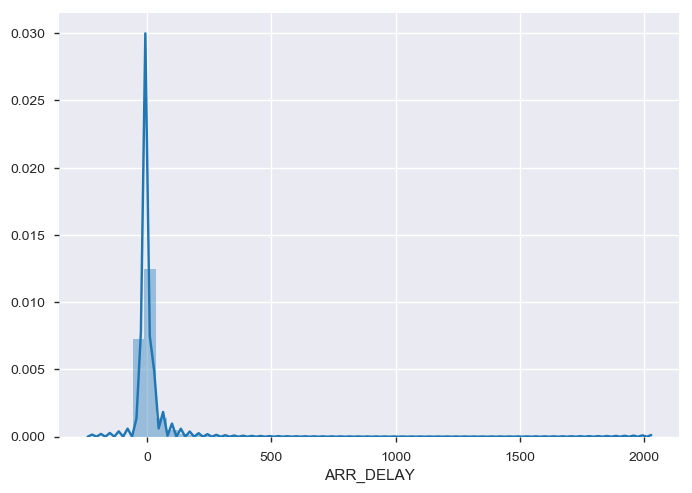

In [8]:
print(df['ARR_DELAY'].describe())
sns.distplot(df['ARR_DELAY'])
plt.show()

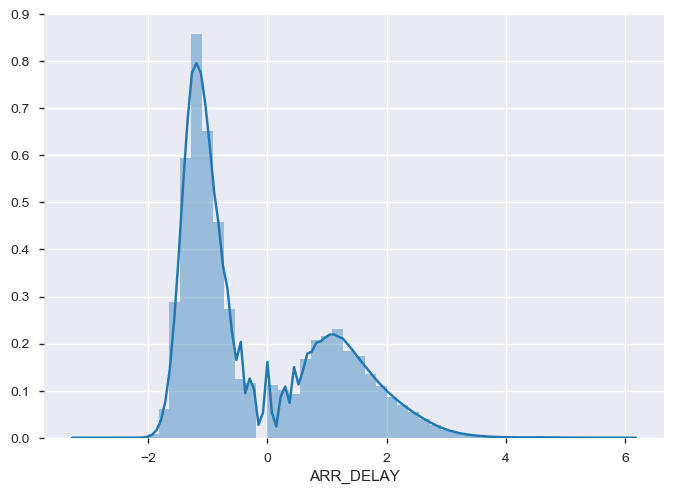

In [9]:
# There are negative values so we can't use box-cox for normality transformation.
# Use hyperbolic tranformation from "On hyperbolic transformations to normality"
# https://www.sciencedirect.com/science/article/pii/S0167947317301408
# Notice that we seem to get a bi-model Guassian distribution with 0 the 
#  splitting point between the 2 Guassians.
delta = 0.3
eps = 0
delay_transf = np.sinh(delta * np.arcsinh(df['ARR_DELAY']) - eps)
sns.distplot(delay_transf)
plt.show()

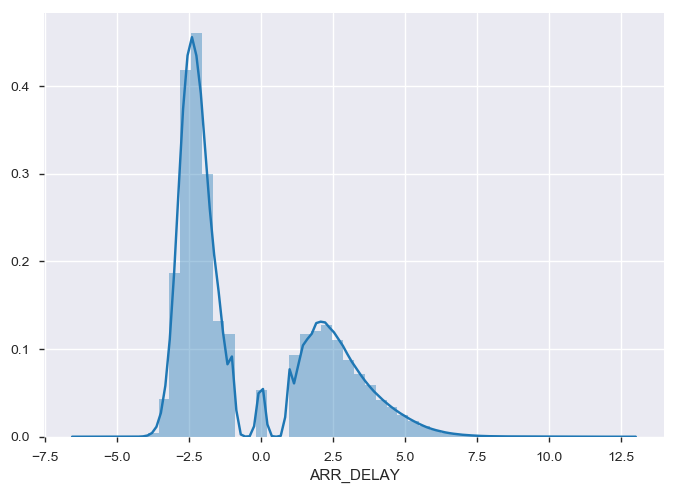

In [10]:
# Cube-root also restuls in bimodal distribution
sns.distplot(np.cbrt(df['ARR_DELAY']))
plt.show()

In [13]:
# Clear and save dataset for training
df.to_csv(
    './data/faa_full.csv', header=True, index=False,
    columns=['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN',
             'DEST', 'ARR_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME',
             'CRS_DEP_HOUR', 'CRS_ARR_HOUR', 'DEP_DELAY'])